#  Q4 - Can you detect cascading failures as delays in one airport create delays in others?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#upload cleaned data file
cleaned_data = pd.read_csv("cleaned_data.csv")

In [3]:
#create coloumn with date and time combined together
cleaned_data['Day'] = cleaned_data['DayofMonth']
cleaned_data['CRSDepTime'] = cleaned_data['CRSDepTime'].astype(str)
cleaned_data['Minutes'] = cleaned_data['CRSDepTime'].str[-2:]
cleaned_data['Hours'] = cleaned_data['CRSDepTime'].str[:-2]
cleaned_data['Date_CRSDeptime'] = pd.to_datetime(cleaned_data[["Year", "Month", "Day","Hours","Minutes"]])
cleaned_data.head()


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Day,Minutes,Hours,Date_CRSDeptime
0,0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,...,0,0,0,0,0,0,1,25,12,2007-01-01 12:25:00
1,1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,...,0,0,0,0,0,0,1,05,19,2007-01-01 19:05:00
2,2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,...,0,3,0,0,0,31,1,30,21,2007-01-01 21:30:00
3,3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,...,0,23,0,0,0,3,1,00,12,2007-01-01 12:00:00
4,4,2007,1,1,1,831.0,830,957.0,1000,WN,...,0,0,0,0,0,0,1,30,8,2007-01-01 08:30:00


In [4]:
#select necessary coloumns
cleaned_data = cleaned_data[['TailNum','Date_CRSDeptime','ArrDelay','DepDelay','Origin','Dest']]
cleaned_data.head()

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest
0,N351,2007-01-01 12:25:00,1.0,7.0,SMF,ONT
1,N370,2007-01-01 19:05:00,8.0,13.0,SMF,PDX
2,N685,2007-01-01 21:30:00,34.0,36.0,SMF,PDX
3,N364,2007-01-01 12:00:00,26.0,30.0,SMF,PDX
4,N480,2007-01-01 08:30:00,-3.0,1.0,SMF,PDX


In [5]:
#sort dataframe in ascending orer based on tailnumber and datetime
cleaned_data = cleaned_data.sort_values(['TailNum','Date_CRSDeptime'])
cleaned_data

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest
7764794,0,2006-01-01 19:45:00,26.0,51.0,JFK,FLL
7686827,0,2006-01-01 20:55:00,-1.0,0.0,CVG,CAK
7765181,0,2006-01-02 19:45:00,770.0,51.0,JFK,FLL
7687653,0,2006-01-02 20:05:00,95.0,100.0,CVG,RDU
7688874,0,2006-01-04 15:15:00,-18.0,-10.0,MEM,CVG
...,...,...,...,...,...,...
7194812,NHZOAL,2007-12-29 15:50:00,1.0,2.0,KOA,HNL
7194831,NHZOAL,2007-12-30 14:30:00,22.0,39.0,OAK,KOA
7194806,NHZOAL,2007-12-30 19:05:00,39.0,53.0,KOA,OAK
7194832,NHZOAL,2007-12-31 11:00:00,45.0,30.0,OAK,KOA


In [6]:
#remove flights with tailnum = 0
cleaned_data = cleaned_data[(cleaned_data['TailNum'] != '0')].copy()
cleaned_data.shape

(14268755, 6)

In [7]:
#lag tailnum and destination down by one row
cleaned_data['previous_tailnum']  = cleaned_data['TailNum'].shift(periods=1)
cleaned_data['previous_dest'] = cleaned_data['Dest'].shift(periods=1)
cleaned_data.head()

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest,previous_tailnum,previous_dest
453520,80009E,2007-01-01 06:00:00,-8.0,-5.0,PHL,IND,NaN,NaN
453516,80009E,2007-01-01 09:00:00,-22.0,-7.0,IND,PHL,80009E,IND
453826,80009E,2007-01-01 11:50:00,26.0,-5.0,PHL,MEM,80009E,PHL
453825,80009E,2007-01-01 14:35:00,1.0,1.0,MEM,XNA,80009E,MEM
453714,80009E,2007-01-01 16:18:00,-4.0,-2.0,XNA,MEM,80009E,XNA


In [8]:
#create function to match previous flight data with current flight data and apply it
def match (a, b):
    
    if a == b:
        return 1
    else:
        return 0
cleaned_data['matched_tailnum'] = cleaned_data.apply(lambda x: match(x['TailNum'],x['previous_tailnum']), axis=1)
cleaned_data.head()

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest,previous_tailnum,previous_dest,matched_tailnum
453520,80009E,2007-01-01 06:00:00,-8.0,-5.0,PHL,IND,NaN,NaN,0
453516,80009E,2007-01-01 09:00:00,-22.0,-7.0,IND,PHL,80009E,IND,1
453826,80009E,2007-01-01 11:50:00,26.0,-5.0,PHL,MEM,80009E,PHL,1
453825,80009E,2007-01-01 14:35:00,1.0,1.0,MEM,XNA,80009E,MEM,1
453714,80009E,2007-01-01 16:18:00,-4.0,-2.0,XNA,MEM,80009E,XNA,1


In [9]:
cleaned_data['matched_origin'] = cleaned_data.apply(lambda x: match(x['Origin'],x['previous_dest']), axis=1)
cleaned_data.head()

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest,previous_tailnum,previous_dest,matched_tailnum,matched_origin
453520,80009E,2007-01-01 06:00:00,-8.0,-5.0,PHL,IND,NaN,NaN,0,0
453516,80009E,2007-01-01 09:00:00,-22.0,-7.0,IND,PHL,80009E,IND,1,1
453826,80009E,2007-01-01 11:50:00,26.0,-5.0,PHL,MEM,80009E,PHL,1,1
453825,80009E,2007-01-01 14:35:00,1.0,1.0,MEM,XNA,80009E,MEM,1,1
453714,80009E,2007-01-01 16:18:00,-4.0,-2.0,XNA,MEM,80009E,XNA,1,1


In [10]:
#assign one to matched_fligth coloumn if both tailnumber and destination to origin match
cleaned_data.loc[(cleaned_data['matched_tailnum'] ==1) & (cleaned_data['matched_origin'] ==1), 'matched_flight'] = 1

In [11]:
#drop all nan values
cleaned_data = cleaned_data.dropna()
cleaned_data

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest,previous_tailnum,previous_dest,matched_tailnum,matched_origin,matched_flight
453516,80009E,2007-01-01 09:00:00,-22.0,-7.0,IND,PHL,80009E,IND,1,1,1.0
453826,80009E,2007-01-01 11:50:00,26.0,-5.0,PHL,MEM,80009E,PHL,1,1,1.0
453825,80009E,2007-01-01 14:35:00,1.0,1.0,MEM,XNA,80009E,MEM,1,1,1.0
453714,80009E,2007-01-01 16:18:00,-4.0,-2.0,XNA,MEM,80009E,XNA,1,1,1.0
453713,80009E,2007-01-01 19:30:00,-2.0,-4.0,MEM,GSP,80009E,MEM,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7194811,NHZOAL,2007-12-28 15:50:00,-24.0,-23.0,KOA,HNL,NHZOAL,KOA,1,1,1.0
7194812,NHZOAL,2007-12-29 15:50:00,1.0,2.0,KOA,HNL,NHZOAL,KOA,1,1,1.0
7194806,NHZOAL,2007-12-30 19:05:00,39.0,53.0,KOA,OAK,NHZOAL,KOA,1,1,1.0
7194832,NHZOAL,2007-12-31 11:00:00,45.0,30.0,OAK,KOA,NHZOAL,OAK,1,1,1.0


In [12]:
#lag arrival delay of flights that match with previous flight
cleaned_data.loc[cleaned_data['matched_flight'] == 1, 'PreviousDelay'] = cleaned_data['ArrDelay'].shift(+1)
cleaned_data

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest,previous_tailnum,previous_dest,matched_tailnum,matched_origin,matched_flight,PreviousDelay
453516,80009E,2007-01-01 09:00:00,-22.0,-7.0,IND,PHL,80009E,IND,1,1,1.0,NaN
453826,80009E,2007-01-01 11:50:00,26.0,-5.0,PHL,MEM,80009E,PHL,1,1,1.0,-22.0
453825,80009E,2007-01-01 14:35:00,1.0,1.0,MEM,XNA,80009E,MEM,1,1,1.0,26.0
453714,80009E,2007-01-01 16:18:00,-4.0,-2.0,XNA,MEM,80009E,XNA,1,1,1.0,1.0
453713,80009E,2007-01-01 19:30:00,-2.0,-4.0,MEM,GSP,80009E,MEM,1,1,1.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7194811,NHZOAL,2007-12-28 15:50:00,-24.0,-23.0,KOA,HNL,NHZOAL,KOA,1,1,1.0,-28.0
7194812,NHZOAL,2007-12-29 15:50:00,1.0,2.0,KOA,HNL,NHZOAL,KOA,1,1,1.0,-24.0
7194806,NHZOAL,2007-12-30 19:05:00,39.0,53.0,KOA,OAK,NHZOAL,KOA,1,1,1.0,1.0
7194832,NHZOAL,2007-12-31 11:00:00,45.0,30.0,OAK,KOA,NHZOAL,OAK,1,1,1.0,39.0


In [13]:
#drop all NAN values
cleaned_data = cleaned_data.dropna()
cleaned_data

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest,previous_tailnum,previous_dest,matched_tailnum,matched_origin,matched_flight,PreviousDelay
453826,80009E,2007-01-01 11:50:00,26.0,-5.0,PHL,MEM,80009E,PHL,1,1,1.0,-22.0
453825,80009E,2007-01-01 14:35:00,1.0,1.0,MEM,XNA,80009E,MEM,1,1,1.0,26.0
453714,80009E,2007-01-01 16:18:00,-4.0,-2.0,XNA,MEM,80009E,XNA,1,1,1.0,1.0
453713,80009E,2007-01-01 19:30:00,-2.0,-4.0,MEM,GSP,80009E,MEM,1,1,1.0,-4.0
454273,80009E,2007-01-02 07:05:00,4.0,4.0,GSP,MEM,80009E,GSP,1,1,1.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7194811,NHZOAL,2007-12-28 15:50:00,-24.0,-23.0,KOA,HNL,NHZOAL,KOA,1,1,1.0,-28.0
7194812,NHZOAL,2007-12-29 15:50:00,1.0,2.0,KOA,HNL,NHZOAL,KOA,1,1,1.0,-24.0
7194806,NHZOAL,2007-12-30 19:05:00,39.0,53.0,KOA,OAK,NHZOAL,KOA,1,1,1.0,1.0
7194832,NHZOAL,2007-12-31 11:00:00,45.0,30.0,OAK,KOA,NHZOAL,OAK,1,1,1.0,39.0


In [14]:
#create function to differentiate flights with delays as 1 and without delay as 0
import warnings
warnings.filterwarnings("ignore")
def delay(a) :
    a = int(a)
    if a <= 0:
        return 0
    else:
        return 1
cleaned_data.loc[:,'current_delay'] = cleaned_data['ArrDelay'].apply(delay)

In [15]:
cleaned_data.loc[:,'previous_delay'] = cleaned_data['PreviousDelay'].apply(delay)

In [16]:
cleaned_data

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest,previous_tailnum,previous_dest,matched_tailnum,matched_origin,matched_flight,PreviousDelay,current_delay,previous_delay
453826,80009E,2007-01-01 11:50:00,26.0,-5.0,PHL,MEM,80009E,PHL,1,1,1.0,-22.0,1,0
453825,80009E,2007-01-01 14:35:00,1.0,1.0,MEM,XNA,80009E,MEM,1,1,1.0,26.0,1,1
453714,80009E,2007-01-01 16:18:00,-4.0,-2.0,XNA,MEM,80009E,XNA,1,1,1.0,1.0,0,1
453713,80009E,2007-01-01 19:30:00,-2.0,-4.0,MEM,GSP,80009E,MEM,1,1,1.0,-4.0,0,0
454273,80009E,2007-01-02 07:05:00,4.0,4.0,GSP,MEM,80009E,GSP,1,1,1.0,-2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194811,NHZOAL,2007-12-28 15:50:00,-24.0,-23.0,KOA,HNL,NHZOAL,KOA,1,1,1.0,-28.0,0,0
7194812,NHZOAL,2007-12-29 15:50:00,1.0,2.0,KOA,HNL,NHZOAL,KOA,1,1,1.0,-24.0,1,0
7194806,NHZOAL,2007-12-30 19:05:00,39.0,53.0,KOA,OAK,NHZOAL,KOA,1,1,1.0,1.0,1,1
7194832,NHZOAL,2007-12-31 11:00:00,45.0,30.0,OAK,KOA,NHZOAL,OAK,1,1,1.0,39.0,1,1


In [17]:
#get crosstab table
pd.crosstab(cleaned_data['previous_delay'], cleaned_data['current_delay'], normalize='columns', margins=False)

current_delay,0,1
previous_delay,,
0,0.670319,0.381863
1,0.329681,0.618137


In [18]:
#remove rows with no previous flight delay
casc_delay = cleaned_data[(cleaned_data['previous_delay']!=0)]

In [19]:
#create function to see if there is a cascading failure
def casc(a):
    if a == 1:
        return 1
    elif a==0 :
        return 0

casc_delay['cascading_failure'] = cleaned_data['current_delay'].apply(casc)

In [20]:
casc_delay.head()

,TailNum,Date_CRSDeptime,ArrDelay,DepDelay,Origin,Dest,previous_tailnum,previous_dest,matched_tailnum,matched_origin,matched_flight,PreviousDelay,current_delay,previous_delay,cascading_failure
453825,80009E,2007-01-01 14:35:00,1.0,1.0,MEM,XNA,80009E,MEM,1,1,1.0,26.0,1,1,1
453714,80009E,2007-01-01 16:18:00,-4.0,-2.0,XNA,MEM,80009E,XNA,1,1,1.0,1.0,0,1,0
454274,80009E,2007-01-02 08:45:00,-1.0,-3.0,MEM,OMA,80009E,MEM,1,1,1.0,4.0,0,1,0
454290,80009E,2007-01-02 16:10:00,-14.0,-2.0,IAH,MEM,80009E,IAH,1,1,1.0,5.0,0,1,0
454767,80009E,2007-01-03 09:23:00,-10.0,-3.0,DTW,CVG,80009E,DTW,1,1,1.0,39.0,0,1,0


In [21]:
#drop NAN values
casc_delay = casc_delay.dropna()

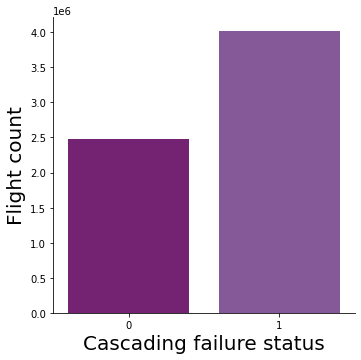

In [22]:
#plot casc_delay data on a catplot
sns.set_palette("BuPu_r")
sns.catplot(data =casc_delay,x ='cascading_failure',kind='count',height=5, aspect=1)
plt.xlabel("Cascading failure status",size=20)
plt.ylabel("Flight count",size=20)
plt.show()